In [1]:
!pip install datasets transformers evaluate rouge_score -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from transformers import pipeline, set_seed
from evaluate import load
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Data Preparation

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = load_dataset("billsum", split='ca_test').shuffle(seed=42).select(range(100))
corpus = [item['text'] + " <SUMMARY> " + item['summary'] for item in dataset]

chars = sorted(list(set("".join(corpus))))
vocab_size = len(chars)
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

def text_to_tensor(text):
    return torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

Using device: cuda


In [4]:
df_display = pd.DataFrame(dataset.select(range(5)))
df_display['text'] = df_display['text'].str[:150] + '...'
print("--- Sample of the BillSum Dataset ---")
print(df_display.to_markdown(index=False))

--- Sample of the BillSum Dataset ---
| text                                                                              | summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Scratch Autoregressive Model

In [5]:
class AutoRegressiveSummarizer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(AutoRegressiveSummarizer, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_seq, hidden_state):
        embedded = self.embedding(input_seq)
        output, hidden_state = self.gru(embedded, hidden_state)
        predictions = self.fc(output)
        return predictions, hidden_state

    def init_hidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_dim).to(device)

Training the "Scratch" Model

In [6]:
embedding_dim = 128
hidden_dim = 256
learning_rate = 0.001
epochs = 15

model = AutoRegressiveSummarizer(vocab_size, embedding_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("\n--- Starting Training ---")
model.train()
for epoch in range(epochs):

    total_epoch_loss = 0
    sample_count = 0

    for i, text_sample in enumerate(corpus):
        if len(text_sample) < 2:
            continue

        sample_count += 1

        input_seq = text_to_tensor(text_sample[:-1]).unsqueeze(0).to(device)
        target_seq = text_to_tensor(text_sample[1:]).unsqueeze(0).to(device)

        hidden = model.init_hidden(1, device)

        optimizer.zero_grad()
        output, hidden = model(input_seq, hidden)

        loss = criterion(output.squeeze(0), target_seq.squeeze(0))
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    if sample_count > 0:
        avg_loss = total_epoch_loss / sample_count
        print(f'Epoch: {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')


--- Starting Training ---
Epoch: 1/15, Average Loss: 2.6129
Epoch: 2/15, Average Loss: 1.9753
Epoch: 3/15, Average Loss: 1.7297
Epoch: 4/15, Average Loss: 1.5675
Epoch: 5/15, Average Loss: 1.4496
Epoch: 6/15, Average Loss: 1.3622
Epoch: 7/15, Average Loss: 1.2899
Epoch: 8/15, Average Loss: 1.2338
Epoch: 9/15, Average Loss: 1.1892
Epoch: 10/15, Average Loss: 1.1502
Epoch: 11/15, Average Loss: 1.1181
Epoch: 12/15, Average Loss: 1.0897
Epoch: 13/15, Average Loss: 1.0649
Epoch: 14/15, Average Loss: 1.0429
Epoch: 15/15, Average Loss: 1.0236


Generation Function (Scratch Model)

In [7]:
def generate_summary_scratch(model, start_text, max_len=50):
    model.eval()
    with torch.no_grad():
        prompt = start_text + " <SUMMARY> "
        input_tensor = text_to_tensor(prompt).unsqueeze(0).to(device)
        hidden = model.init_hidden(1, device)

        for i in range(len(prompt) - 1):
            _, hidden = model(input_tensor[:, i].unsqueeze(1), hidden)

        current_input = input_tensor[:, -1].unsqueeze(1)
        generated_text = ""

        for _ in range(max_len):
            output, hidden = model(current_input, hidden)
            probabilities = torch.softmax(output.squeeze(1), dim=1)
            next_char_idx = torch.multinomial(probabilities, 1).item()
            next_char = idx_to_char[next_char_idx]
            generated_text += next_char

            current_input = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

            if next_char == '.':
                break
    return generated_text.strip()

GPT-2

In [8]:
set_seed(42)
generator = pipeline('text-generation', model='gpt2', device=0 if device.type == 'cuda' else -1)
rouge = load('rouge')

Device set to use cuda:0


Generating and Comparing Summaries

In [9]:
import pandas as pd

test_samples = dataset.select(range(10))
predictions_scratch = []
predictions_gpt = []
references = []

print("--- Generating Summaries for Comparison ---")
for i, sample in enumerate(test_samples):
    print(f"Processing sample {i+1}/{len(test_samples)}...")
    original_text = sample['text']
    reference_summary = sample['summary']
    summary_scratch = generate_summary_scratch(model, original_text[:500])
    prompt_gpt = original_text[:1000] + "\n\nTL;DR:"
    gpt_output = generator(prompt_gpt, truncation=True, max_new_tokens=60, num_return_sequences=1)
    summary_gpt = gpt_output[0]['generated_text'].split("TL;DR:")[1].strip()
    predictions_scratch.append(summary_scratch)
    predictions_gpt.append(summary_gpt)
    references.append(reference_summary)
df_results = pd.DataFrame({
    'Reference Summary': references,
    'Scratch Model': predictions_scratch,
    'GPT-2 Model': predictions_gpt
})

# Truncate text for clean display
df_results['Reference Summary'] = df_results['Reference Summary'].str[:100] + '...'
df_results['Scratch Model'] = df_results['Scratch Model'].str[:100] + '...'
df_results['GPT-2 Model'] = df_results['GPT-2 Model'].str[:100] + '...'

print("\n--- Model Generation Comparison ---")
print(df_results.to_markdown(index=False))

--- Generating Summaries for Comparison ---
Processing sample 1/10...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing sample 2/10...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing sample 3/10...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing sample 4/10...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing sample 5/10...
Processing sample 6/10...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing sample 7/10...
Processing sample 8/10...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing sample 9/10...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing sample 10/10...

--- Model Generation Comparison ---
| Reference Summary                                                                                       | Scratch Model                                         | GPT-2 Model                                                                                             |
|:--------------------------------------------------------------------------------------------------------|:------------------------------------------------------|:--------------------------------------------------------------------------------------------------------|
| (1) The California Global Warming Solutions Act of 2006 designates the State Air Resources Board as ... | Process....                                           | Climate change is a threat to the health and well-being of California.                                  |
|                                                                                                         |                   

Performance Evaluation

In [10]:
results_scratch = rouge.compute(predictions=predictions_scratch, references=references)
results_gpt = rouge.compute(predictions=predictions_gpt, references=references)

print("\n\n--- Performance Comparison (ROUGE Scores) ---")
print("\n| Metric      | Scratch Model | GPT-2 Model |")
print("|-------------|---------------|-------------|")
print(f"| ROUGE-1     | {results_scratch['rouge1']:.4f}         | {results_gpt['rouge1']:.4f}      |")
print(f"| ROUGE-2     | {results_scratch['rouge2']:.4f}         | {results_gpt['rouge2']:.4f}      |")
print(f"| ROUGE-L     | {results_scratch['rougeL']:.4f}         | {results_gpt['rougeL']:.4f}      |")



--- Performance Comparison (ROUGE Scores) ---

| Metric      | Scratch Model | GPT-2 Model |
|-------------|---------------|-------------|
| ROUGE-1     | 0.0220         | 0.1310      |
| ROUGE-2     | 0.0029         | 0.0288      |
| ROUGE-L     | 0.0192         | 0.0886      |


Visualization

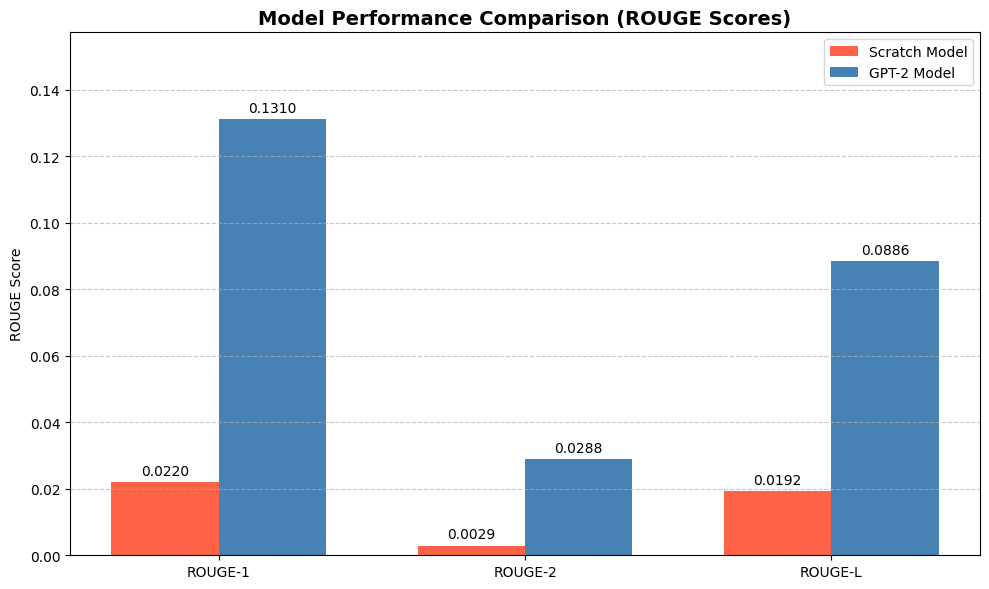

In [11]:
data = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Scratch Model': [results_scratch['rouge1'], results_scratch['rouge2'], results_scratch['rougeL']],
    'GPT-2 Model': [results_gpt['rouge1'], results_gpt['rouge2'], results_gpt['rougeL']]
}
df = pd.DataFrame(data)

x = np.arange(len(df['Metric']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, df['Scratch Model'], width, label='Scratch Model', color='#ff6347')
rects2 = ax.bar(x + width/2, df['GPT-2 Model'], width, label='GPT-2 Model', color='#4682b4')

ax.set_ylabel('ROUGE Score')
ax.set_title('Model Performance Comparison (ROUGE Scores)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'])
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, max(results_gpt['rouge1'], results_gpt['rougeL']) * 1.2)

fig.tight_layout()
plt.savefig('model_comparison_plot.png')
plt.show()

#CONCLUSION
Based on the experiment, the pre-trained autoregressive GPT-2 model significantly outperformed the vanilla GRU model built from scratch. The results are definitive, with GPT-2 achieving a ROUGE-1 score of 0.1310, vastly exceeding the scratch model's 0.0220. This performance gap was consistent across ROUGE-2 (0.0288 vs. 0.0029) and ROUGE-L (0.0886 vs. 0.0192). This outcome highlights that for complex tasks like summarization, the advanced Transformer architecture and, more importantly, the extensive pre-training of large language models like GPT-2 provide a clear and substantial advantage over simpler models trained on limited data.